In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 1000

In [2]:
from odapi.connectors import Irceline
from odapi.settings import settings
settings.logger.setLevel(40)

In [3]:
c = Irceline()

In [4]:
s = c.select(sitekey='41R001')

In [5]:
r = c.get_records(s, start='2020', stop='2020-06-08')

In [6]:
d = r.merge(s[['serieid', 'measurekey']]).pivot_table(index='start', columns='measurekey', values='value')

In [7]:
d.index = d.index.tz_convert('CET').tz_localize(None)

In [8]:
d = d.fillna(d.rolling(5, min_periods=1).mean())

In [9]:
df = []
for i in range(5):
    df.append(d.shift(-i).add_suffix('_{}'.format(i)))
df = pd.concat(df, axis=1)   

In [10]:
df['Month'] = df.index.month
df['Time'] = (df.index - df.index.floor('1D')).total_seconds()/60**2
df['DoW'] = df.index.dayofweek

In [11]:
df = df.interpolate()

In [12]:
X = df.copy()

In [13]:
y = X.pop('PM-2.5_0')

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [17]:
regr_rf = RandomForestRegressor(n_estimators=100, random_state=1234, verbose=1)

In [18]:
regr_rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.3s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1234, verbose=1, warm_start=False)

In [19]:
decision_forest_score = regr_rf.score(X_test, y_test)
decision_forest_score

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.9325313876268644

In [20]:
regr_rf_pred = regr_rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [21]:
# The mean squared error
print("Root mean squared error: %.2f"
      % np.sqrt(mean_squared_error(y_test, regr_rf_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, regr_rf_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, regr_rf_pred))

Root mean squared error: 1.81
Mean absolute error: 1.22
R-squared: 0.93


In [22]:
regr_rf.feature_importances_

array([1.07480375e-03, 6.45933215e-03, 1.21713136e-03, 9.98508429e-04,
       1.61802128e-03, 6.48359416e-02, 2.54940010e-03, 5.84960854e-04,
       9.98726152e-04, 1.49722786e-03, 1.11132869e-03, 1.76055456e-04,
       8.08553918e-04, 1.04125783e-02, 8.56829779e-03, 7.07447207e-04,
       2.31979188e-02, 7.37836211e-01, 1.75376020e-03, 1.58540337e-03,
       4.82222558e-04, 1.37057011e-03, 1.05628549e-03, 3.08171858e-04,
       3.61417536e-03, 3.55344389e-04, 4.60514847e-03, 1.24801049e-03,
       8.82119792e-03, 2.26278890e-02, 8.52390184e-04, 5.38870448e-04,
       4.72439916e-04, 1.41111675e-03, 7.82851837e-04, 7.13291083e-04,
       4.89681044e-04, 4.92484871e-04, 1.36375236e-02, 4.20667344e-03,
       3.84166199e-03, 2.18108477e-03, 7.48874440e-04, 1.89882427e-03,
       2.00202627e-03, 5.19548619e-03, 2.44699664e-03, 3.04826952e-04,
       9.78720331e-03, 4.17772221e-04, 1.46156767e-02, 1.42798759e-03,
       3.59906658e-03, 9.59218613e-04, 1.12605438e-03, 6.01852371e-04,
      

In [23]:
imp = pd.DataFrame(np.array([X.columns, regr_rf.feature_importances_]).T, columns=['Feature', 'Importance'])
imp.sort_values('Importance', ascending=False)

,Feature,Importance
17,PM-2.5_1,0.737836
5,PM-10.0_0,0.0648359
16,PM-10.0_1,0.0231979
29,PM-2.5_2,0.0226279
50,NO2_4,0.0146157
38,NO2_3,0.0136375
13,NO_1,0.0104126
48,CO_4,0.0097872
28,PM-10.0_2,0.0088212
14,NO2_1,0.0085683


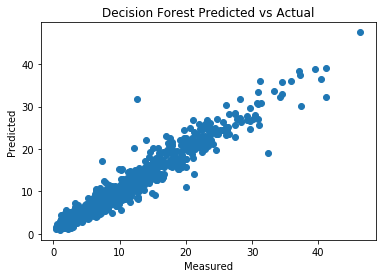

In [24]:
plt.scatter(y_test, regr_rf_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Decision Forest Predicted vs Actual')
plt.show()